In [1]:
# Python imports
import os

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt

# 0. Constants

In [2]:
BATCH_SIZE = 10
LEARNING_RATES = [0.0001, 0.001, 0.01, 0.1, 1, 10]
EPOCHS = 30
WIDTH, HEIGHT = 28, 28
SAVED_FILENAME = 'MNIST-MLP-1-1'
LAYER_SIZE = 64

# 1. Dataset

In [3]:
# Load datasets.
dataset_training = torchvision.datasets.MNIST('./data', download=True, train=True, transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST('./data', download=True, train=False, transform=torchvision.transforms.ToTensor())

# Create data loaders.
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# 2. Models

In [4]:
# Create a model for each learning rate.
models = []
for i in range(len(LEARNING_RATES)):
    models.append(torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(WIDTH*HEIGHT, LAYER_SIZE),
        torch.nn.Linear(LAYER_SIZE, 10),
        torch.nn.Softmax(dim=1)
    ))

# 3. Training

## 3.1. Helper Functions

In [5]:
def calculateStatistics(dataloader, model, loss_fn):
    with torch.no_grad():
        num_batches = len(dataloader)
        num_samples = len(dataloader.dataset)
        loss, correct = 0, 0

        for images, labels in dataloader:
            # Make predictions.
            preds = model(images)

            # Calculate the loss.
            loss += loss_fn(preds, labels)

            # Calculate the number of correctnesses.
            correct += (preds.argmax(dim=1) == labels).type(dtype=torch.float32).sum()

        # Calculate the mean loss and correct.
        loss /= num_batches
        correct /= num_samples

    return loss, correct

## 3.2. Training

In [6]:
def load(models):
    # Retrieve saved data.
    data = torch.load(f'saved/{SAVED_FILENAME}.pt')

    # Construct structs losses, corrects, losses_test and corrects_test for returning.
    losses, corrects, losses_test, corrects_test = [], [], [], []

    # Resume model from saved data.
    for i in range(len(LEARNING_RATES)):
        state_dict = data[i]['state_dict']
        models[i].load_state_dict(state_dict)
        losses.append(data[i]['losses'])
        corrects.append(data[i]['corrects'])
        losses_test.append(data[i]['losses_test'])
        corrects_test.append(data[i]['corrects_test'])

    # Return losses and accuracies for training and testing.
    return losses, corrects, losses_test, corrects_test

def save(models, losses, corrects, losses_test, corrects_test):
    # Create folder 'saved' if it does not exist.
    if not os.path.exists('saved'):
        os.makedirs('saved')

    # Construct the struct of data to save.
    data = []
    for i in range(len(LEARNING_RATES)):
        data.append({
            'state_dict': models[i].state_dict(),
            'losses': losses[i],
            'corrects': corrects[i],
            'losses_test': losses_test[i],
            'corrects_test': corrects_test[i],
        })

    # Save data to the file.
    torch.save(data, f'saved/{SAVED_FILENAME}.pt')

def train(model, epochs, learning_rate):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)

    # Define losses and corrects for training and test.
    losses, corrects = [], []
    losses_test, corrects_test = [], []

    # Calculate losses and corrects before training.
    loss, correct = calculateStatistics(dataloader_training, model, loss_fn)
    losses.append(loss)
    corrects.append(correct)
    loss_test, correct_test = calculateStatistics(dataloader_test, model, loss_fn)
    losses_test.append(loss)
    corrects_test.append(correct_test)

    # Run epochs.
    for epoch in range(epochs):

        # Run one epoch for training.
        num_batches = len(dataloader_training)
        num_samples = len(dataloader_training.dataset)
        loss_epoch, correct_epoch = 0, 0
        for batch, [images, labels] in enumerate(dataloader_training):
            # Make predictions.
            pred = model(images)

            # Calculate the loss.
            loss = loss_fn(pred, labels)
            loss_epoch += loss.item()

            # Calculate the number of correctness.
            correct_epoch += (pred.argmax(dim=1) == labels).type(dtype=torch.float32).sum().item()

            # Calculate gradients.
            optimizer.zero_grad()
            loss.backward()

            # Optimization.
            optimizer.step()

            if (batch + 1) % 1000 == 0:
                loss = loss.item()
            
        # Calculate the mean loss across all batches.
        loss_epoch /= num_batches
        losses.append(loss_epoch)

        # Calculate the mean number of correctness across all batches.
        correct_epoch /= num_samples
        corrects.append(correct_epoch)

        # Calculate loss and correct for test.
        loss_test, correct_test = calculateStatistics(dataloader_test, model, loss_fn)
        losses_test.append(loss_test)
        corrects_test.append(correct_test)

    # Return losses and accuracies for training and testing.
    return losses, corrects, losses_test, corrects_test

In [7]:
if os.path.exists(f'saved/{SAVED_FILENAME}.pt'):
    losses, corrects, losses_test, corrects_test = load(models)
else:
    losses, corrects, losses_test, corrects_test = [], [], [], []
    for i in range(len(LEARNING_RATES)):
        print(f'Training the model for learning rate {LEARNING_RATES[i]}...')
        losses_1_model, corrects_1_model, losses_test_1_model, corrects_test_1_model = train(models[i], EPOCHS, LEARNING_RATES[i])
        losses.append(losses_1_model)
        corrects.append(corrects_1_model)
        losses_test.append(losses_test_1_model)
        corrects_test.append(corrects_test_1_model)
    save(models, losses, corrects, losses_test, corrects_test)

## 3.3. Visualization of the Training Process

### 3.3.1. Visualization of Losses and Accuracies

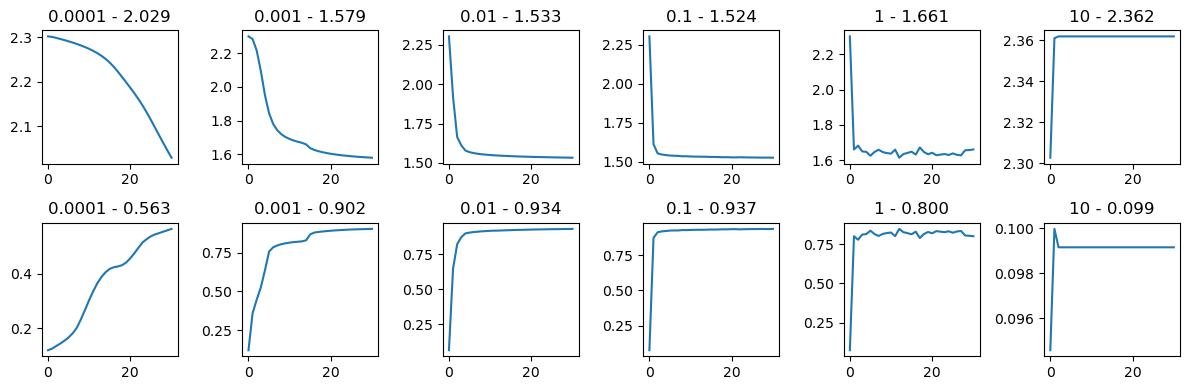

In [10]:
fig, axs = plt.subplots(2, len(LEARNING_RATES), figsize=(12, 4))
for i in range(len(LEARNING_RATES)):
    axs[0, i].plot(losses[i])
    axs[0, i].set_title(f'{LEARNING_RATES[i]} - {losses[i][EPOCHS]:.3f}')
    axs[1, i].plot(corrects[i])
    axs[1, i].set_title(f'{LEARNING_RATES[i]} - {corrects[i][EPOCHS]:.3f}')
plt.tight_layout()